# Airbnb Recommendation System - Tokyo

![title image](https://www.marketingweek.com/content/uploads/2014/11/Brand_Case_Study3.gif)

# Business Problem
Airbnb aims to enhance its presence in Japan by identifying popular properties in Tokyo and expanding its business to other cities outside the capital. Airbnb wants to understand the key factors that contribute to the popularity of properties in Tokyo. These were assessed based on price per night, amenities offered, and user ratings.

Airbnb aims to align its growth strategy with the Japanese government's initiative to promote tourism in areas outside major cities. As of April 29, 2023, the Japanese government no longer requires vaccination certificates or negative Covid tests for tourists. The removal of these requirements may positively impact tourism, and Airbnb should leverage this opportunity to attract more travelers. 

Develop a recommendation system to guide new users in rating properties and receive tailored recommendations based on their preferences.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
import ast
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

* Reviews Dataset

In [ ]:
#reviews_df = pd.read_csv('data/reviews.csv')

In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451682 entries, 0 to 451681
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     451682 non-null  int64 
 1   id             451682 non-null  int64 
 2   date           451682 non-null  object
 3   reviewer_id    451682 non-null  int64 
 4   reviewer_name  451681 non-null  object
 5   comments       451638 non-null  object
dtypes: int64(3), object(3)
memory usage: 20.7+ MB


In [6]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,197677,554285,2011-09-21,1002142,Pablo,Couldn’t get any better!\r<br/>\r<br/>The apar...
1,197677,627651,2011-10-14,1031940,Ana & Ricardo,The apartment is bigger than it looks in the p...
2,197677,733040,2011-11-21,1097040,Samuel,The appartement is perfect for a couple! It is...
3,197677,755841,2011-11-30,1183674,Lisa,We had a terrific stay at Yoshimi and Marek's ...
4,197677,852938,2012-01-09,1538004,Langan,We loved our stay at the Oshiage Holiday Apart...


* Listings Dataset

In [ ]:
#listings = pd.read_csv('data/listings.csv')

In [8]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234 entries, 0 to 12233
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12234 non-null  int64  
 1   listing_url                                   12234 non-null  object 
 2   scrape_id                                     12234 non-null  int64  
 3   last_scraped                                  12234 non-null  object 
 4   source                                        12234 non-null  object 
 5   name                                          12234 non-null  object 
 6   description                                   12234 non-null  object 
 7   neighborhood_overview                         8400 non-null   object 
 8   picture_url                                   12234 non-null  object 
 9   host_id                                       12234 non-null 

In [126]:
listing_details = listings[listings['id'] == 49084102]
listing_details[['room_type','number_of_reviews','number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'reviews_per_month']]


,room_type,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,reviews_per_month
6295,Entire home/apt,971,536,39,2021-07-04,2023-09-23,4.83,35.83


In [7]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,city scrape,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
1,5240174,https://www.airbnb.com/rooms/5240174,20230924051543,2023-09-24,previous scrape,Rental unit in Shibuya-ku · ★4.52 · Studio · 1...,Minimalist simple grey-color interior room. My...,NaN,https://a0.muscache.com/pictures/b0b55fef-80cb...,24477517,...,4.83,4.29,4.30,M130005396,t,4,4,0,0,1.89
2,5262640,https://www.airbnb.com/rooms/5262640,20230924051543,2023-09-24,city scrape,Rental unit in Nakano-ku · ★4.80 · 1 bedroom ·...,It takes 5 min walk to Fujimidai Sta.. You can...,No smoking in the room<br />No outdoor shoes a...,https://a0.muscache.com/pictures/281f8d6f-eb4a...,17736560,...,4.87,4.61,4.77,Hotels and Inns Business Act | 中野区保健所 | 30中環生環...,f,9,9,0,0,0.59
3,776070,https://www.airbnb.com/rooms/776070,20230924051543,2023-09-24,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.84,4.91,M130000243,f,1,0,1,0,1.88
4,905944,https://www.airbnb.com/rooms/905944,20230924051543,2023-09-24,city scrape,Rental unit in Shibuya · ★4.77 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.78,4.78,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.52


# EDA

* We only need the reviews and listings datasets. Merge the 2 together

In [9]:
merged_df = pd.merge(reviews_df, listings, left_on='listing_id', right_on='id', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451682 entries, 0 to 451681
Data columns (total 81 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   listing_id                                    451682 non-null  int64  
 1   id_x                                          451682 non-null  int64  
 2   date                                          451682 non-null  object 
 3   reviewer_id                                   451682 non-null  int64  
 4   reviewer_name                                 451681 non-null  object 
 5   comments                                      451638 non-null  object 
 6   id_y                                          451682 non-null  int64  
 7   listing_url                                   451682 non-null  object 
 8   scrape_id                                     451682 non-null  int64  
 9   last_scraped                                  45

In [9]:
merged_df.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,id_y,listing_url,scrape_id,last_scraped,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,554285,2011-09-21,1002142,Pablo,Couldn’t get any better!\r<br/>\r<br/>The apar...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
1,197677,627651,2011-10-14,1031940,Ana & Ricardo,The apartment is bigger than it looks in the p...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
2,197677,733040,2011-11-21,1097040,Samuel,The appartement is perfect for a couple! It is...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
3,197677,755841,2011-11-30,1183674,Lisa,We had a terrific stay at Yoshimi and Marek's ...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
4,197677,852938,2012-01-09,1538004,Langan,We loved our stay at the Oshiage Holiday Apart...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19


In [10]:
merged_df.isna().sum()

listing_id                                      0
id_x                                            0
date                                            0
reviewer_id                                     0
reviewer_name                                   1
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 81, dtype: int64

Some of the reviews are from 2011, we only want the recent ones

In [11]:
merged_df['date'].value_counts()

date
2023-07-30    931
2023-08-14    850
2023-07-17    848
2023-05-06    832
2023-05-07    829
             ... 
2014-12-20      1
2013-12-15      1
2014-01-10      1
2014-01-18      1
2011-09-21      1
Name: count, Length: 3682, dtype: int64

* Checking num_of_reviews column. Will need to filter this by at least 10 reviews

In [11]:
merged_df['listing_id'].value_counts()

listing_id
27750681              2023
49084102               971
44125369               966
44637473               782
25377337               779
                      ... 
41653901                 1
41805631                 1
924340394945850701       1
41573195                 1
983031277017558192       1
Name: count, Length: 10776, dtype: int64

In [12]:
merged_df["listing_id"].nunique()

10776

* Looking at property_type columns.

In [13]:
merged_df['property_type'].value_counts()

property_type
Entire rental unit                    246883
Entire home                            64144
Private room in home                   21650
Private room in rental unit            16571
Entire condo                           13891
Room in hotel                          13041
Room in aparthotel                     12902
Room in boutique hotel                 12768
Entire serviced apartment               8245
Private room in hostel                  5816
Entire villa                            4639
Room in hostel                          4053
Private room in serviced apartment      3736
Shared room in hostel                   3608
Shared room in rental unit              2403
Entire loft                             2233
Private room in condo                   1478
Private room in guesthouse              1473
Entire townhouse                        1281
Hut                                     1257
Room in ryokan                          1034
Shared room in home                      

In [14]:
merged_df['number_of_reviews'].value_counts()

number_of_reviews
37     3367
36     3240
39     3120
41     3116
19     3116
       ... 
236     236
226     226
224     224
205     205
202     202
Name: count, Length: 351, dtype: int64

# Data Processing

In [10]:
# Convert date column to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Filter by date since May 1, 2023
merged_df = merged_df[merged_df['date'] >= '2023-05-01']

# Filter by number of reviews
merged_df = merged_df[merged_df['number_of_reviews'] > 10]

# drop unnecessary columns
col = ['id_x', 'id_y', 'source', 'host_id', 'host_name', 'calculated_host_listings_count', 'availability_365', 'host_id', 'host_url',
       'host_listings_count', 'host_total_listings_count', 'scrape_id', 'last_scraped',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed',  'minimum_nights',
       'calendar_updated', 
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'first_review', 'last_review',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'license', 'instant_bookable',
       'calculated_host_listings_count', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
       'reviews_per_month', 'host_since', 'host_location', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood',
       'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'                                           
       ]

merged_df.drop(col, axis=1, inplace=True)

# rename columns
merged_df.rename(columns={'review_scores_rating': 'rating', 'accomodates': 'guest_limit', 'neighbourhood_cleansed': 'neighborhood'}, inplace=True)


In [10]:
# sanity check
merged_df = merged_df.reset_index(drop=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74975 entries, 0 to 74974
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              74975 non-null  int64         
 1   date                    74975 non-null  datetime64[ns]
 2   reviewer_id             74975 non-null  int64         
 3   reviewer_name           74975 non-null  object        
 4   comments                74965 non-null  object        
 5   listing_url             74975 non-null  object        
 6   name                    74975 non-null  object        
 7   description             74975 non-null  object        
 8   neighborhood_overview   54749 non-null  object        
 9   picture_url             74975 non-null  object        
 10  neighborhood            74975 non-null  object        
 11  latitude                74975 non-null  float64       
 12  longitude               74975 non-null  float6

In [11]:
# Rename the dataframe to appropriate name and save cleaned dataset as CSV
df = merged_df
#df.to_csv('data/airbnb_listings.csv', index=False)

In [22]:
df.head()

,listing_id,date,reviewer_id,reviewer_name,comments,listing_url,name,description,neighborhood_overview,picture_url,...,bathrooms_text,bedrooms,beds,amenities,price,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,rating
0,197677,2023-05-05,80161764,Sabrina,"Friendly welcome, well equiped accomodation. E...",https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
1,197677,2023-05-30,14533360,Liang-Pin,Marek is a very friendly host. He was very kin...,https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
2,197677,2023-08-13,390831971,Ainsley,It is a nice and peaceful location and totally...,https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
3,776070,2023-05-19,20824347,Ikuko,Keiさんのご家族はとても仲良しで、自然体で受け入れてくださり<br/>とても居心地の良い雰...,https://www.airbnb.com/rooms/776070,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,...,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...","$8,902.00",t,248,18,1,4.98
4,776070,2023-05-28,275284916,Jean-Daniel,It is an amazing place to stay with a japanese...,https://www.airbnb.com/rooms/776070,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,...,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...","$8,902.00",t,248,18,1,4.98


# Visualizations

In [43]:
df['property_type'].value_counts()

property_type
Entire rental unit                    39828
Entire home                            9512
Room in boutique hotel                 2990
Room in hotel                          2878
Private room in rental unit            2712
Private room in home                   2692
Entire condo                           2574
Room in aparthotel                     2437
Entire serviced apartment              2196
Private room in hostel                 1256
Entire villa                            791
Room in hostel                          776
Private room in serviced apartment      643
Shared room in hostel                   552
Shared room in hotel                    375
Entire loft                             317
Private room in guesthouse              213
Shared room in ryokan                   201
Private room in hut                     194
Shared room in rental unit              172
Private room in condo                   168
Hut                                     152
Room in serviced a

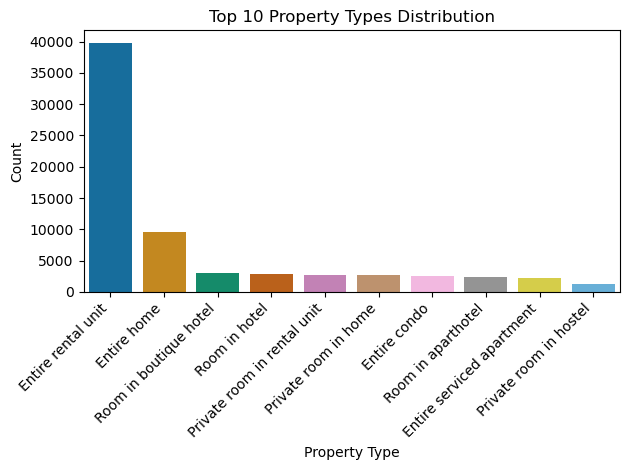

In [24]:
top10_property_types = df['property_type'].value_counts().nlargest(10)
sns.set_palette("colorblind")

sns.barplot(x=top20_property_types.index, y=top20_property_types.values)

plt.title('Top 10 Property Types Distribution')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

In [18]:
df["room_type"].value_counts()

room_type
Entire home/apt    57570
Private room       14274
Shared room         1569
Hotel room          1562
Name: count, dtype: int64

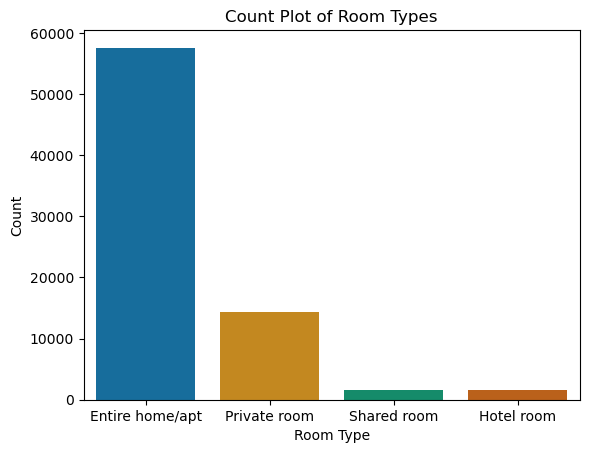

In [25]:
sns.countplot(x='room_type', data=df, palette='colorblind')

plt.title('Count Plot of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')

plt.show()

* Exploring frequetly reviewed properties

In [56]:
df['listing_id'].value_counts()

popular = df['listing_id'].value_counts()
popular

listing_id
27750681              363
44125369              340
847456265351637680    269
49084102              244
50381026              178
                     ... 
48270489                1
19061679                1
43806377                1
39953244                1
26171785                1
Name: count, Length: 6657, dtype: int64

In [57]:
popular.nunique()

92

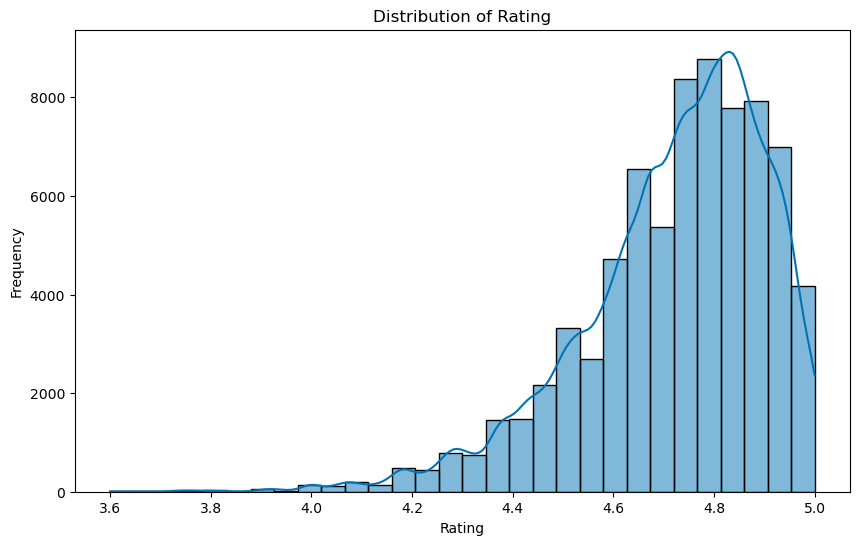

In [26]:
plt.figure(figsize=(10, 6))

# Distribution plot for review scores rating
sns.histplot(df['rating'], bins=30, kde=True)

plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.show()

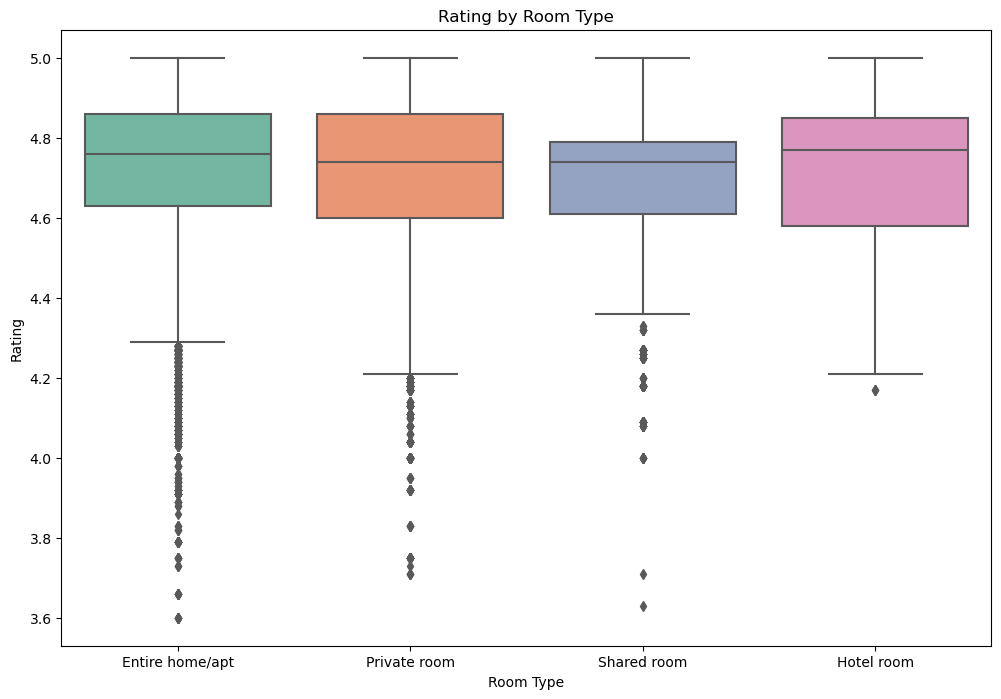

In [27]:
# Box plot of review scores rating by room type
plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y='rating', data=df, palette='Set2')

plt.title('Rating by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Rating')

plt.show()

In [ ]:
#sns.pairplot(df[['number_of_reviews', 'review_scores_rating', 'beds']])
#plt.suptitle('Pair Plot of Numerical Variables', y=1.02)
#plt.show()


* For heatmap
import folium
from folium.plugins import HeatMap

Assuming 'latitude' and 'longitude' are the names of the columns in your filtered_df
latitude_column = 'latitude'
longitude_column = 'longitude'

Create a base map centered around Tokyo
tokyo_coordinates = [35.6895, 139.6917]
tokyo_map = folium.Map(location=tokyo_coordinates, zoom_start=12, lang='en')

Add a heatmap layer based on the latitude and longitude of the listings
HeatMap(filtered_df[[latitude_column, longitude_column]].values, radius=15).add_to(tokyo_map)

Save the map as an HTML file
tokyo_map.save('tokyo_heatmap.html')

Display the map (optional)
tokyo_map

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74975 entries, 283 to 451235
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              74975 non-null  int64         
 1   date                    74975 non-null  datetime64[ns]
 2   reviewer_name           74975 non-null  object        
 3   comments                74965 non-null  object        
 4   listing_url             74975 non-null  object        
 5   name                    74975 non-null  object        
 6   description             74975 non-null  object        
 7   neighborhood_overview   54749 non-null  object        
 8   picture_url             74975 non-null  object        
 9   neighbourhood           54749 non-null  object        
 10  neighbourhood_cleansed  74975 non-null  object        
 11  latitude                74975 non-null  float64       
 12  longitude               74975 non-null  float64 

* Exploring price per night column

In [31]:
df['price']

0        $12,000.00
1        $12,000.00
2        $12,000.00
3         $8,902.00
4         $8,902.00
            ...    
74970    $27,714.00
74971    $27,714.00
74972    $27,714.00
74973    $27,714.00
74974    $27,714.00
Name: price, Length: 74975, dtype: object

In [34]:
# Clean and convert 'price' column to numeric format
df['price'] = pd.to_numeric(df['price'].replace('[^\d.]', '', regex=True), errors='coerce')

# Assuming exchange rate of 1 JPY = 0.0091 USD
exchange_rate = 0.0091

# Convert 'price' column to USD
df['price_in_usd'] = df['price'] * exchange_rate

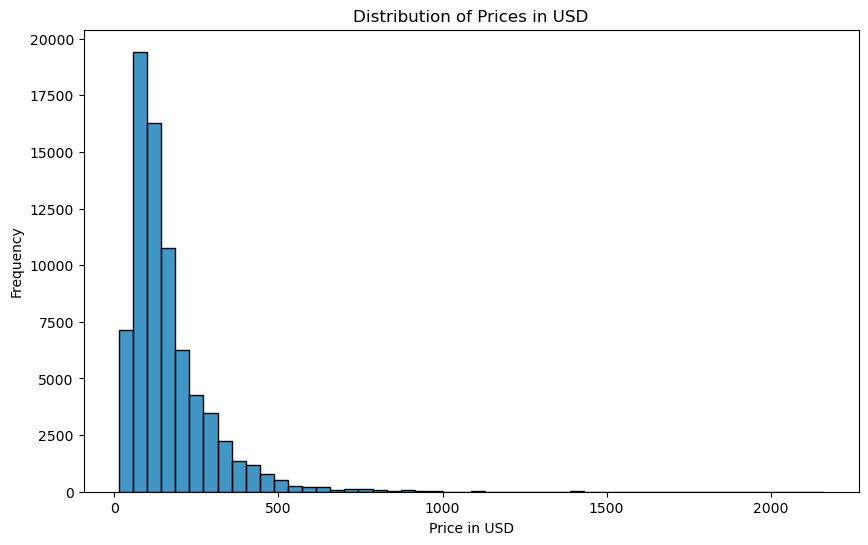

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price_in_usd'], bins=50)
plt.title('Distribution of Prices in USD')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

In [37]:
average_price_by_category = df.groupby('property_type')['price_in_usd'].mean().sort_values(ascending=False)
print(average_price_by_category)

property_type
Private room in resort                607.097400
Treehouse                             426.398700
Entire villa                          368.764592
Farm stay                             359.841300
Room in serviced apartment            337.750228
Entire vacation home                  329.697630
Entire home                           287.026278
Entire cottage                        278.196100
Entire bungalow                       276.903900
Entire place                          268.185938
Barn                                  248.157000
Earthen home                          227.500000
Room in aparthotel                    186.801253
Entire cabin                          182.000000
Room in boutique hotel                173.733700
Hut                                   171.808838
Entire condo                          161.942295
Tiny home                             161.304072
Entire townhouse                      160.337607
Entire rental unit                    151.718476
Entire

* investigate the relationship between prices and review scores. Is there a correlation between higher prices and better review scores?

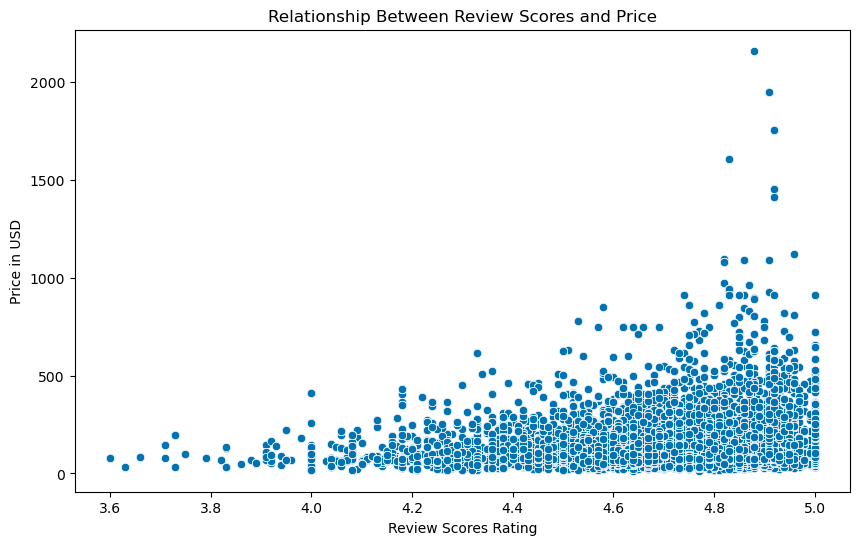

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='price_in_usd', data=df)
plt.title('Relationship Between Review Scores and Price')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price in USD')
plt.show()


* * make y axis bigger and focus on removing the outliers, zoom in on the graph.

In [41]:
amenities_counts = df['amenities'].apply(lambda x: pd.Series(eval(x))).stack().value_counts()
print(amenities_counts)


Hair dryer               74249
Essentials               73369
Smoke alarm              72730
Shampoo                  69176
Hangers                  68737
                         ...  
P&G body soap                1
SHISEIDO conditioner         1
MARKS&WEB conditioner        1
汎用品 conditioner              1
Fast wifi – 305 Mbps         1
Name: count, Length: 1622, dtype: int64


In [46]:
top_n_amenities = 10 
top_amenities_counts = amenities_counts.head(top_n_amenities)
print(top_amenities_counts)


Hair dryer           74249
Essentials           73369
Smoke alarm          72730
Shampoo              69176
Hangers              68737
Hot water            67183
Wifi                 67001
Fire extinguisher    65507
Refrigerator         64098
Microwave            64012
Name: count, dtype: int64


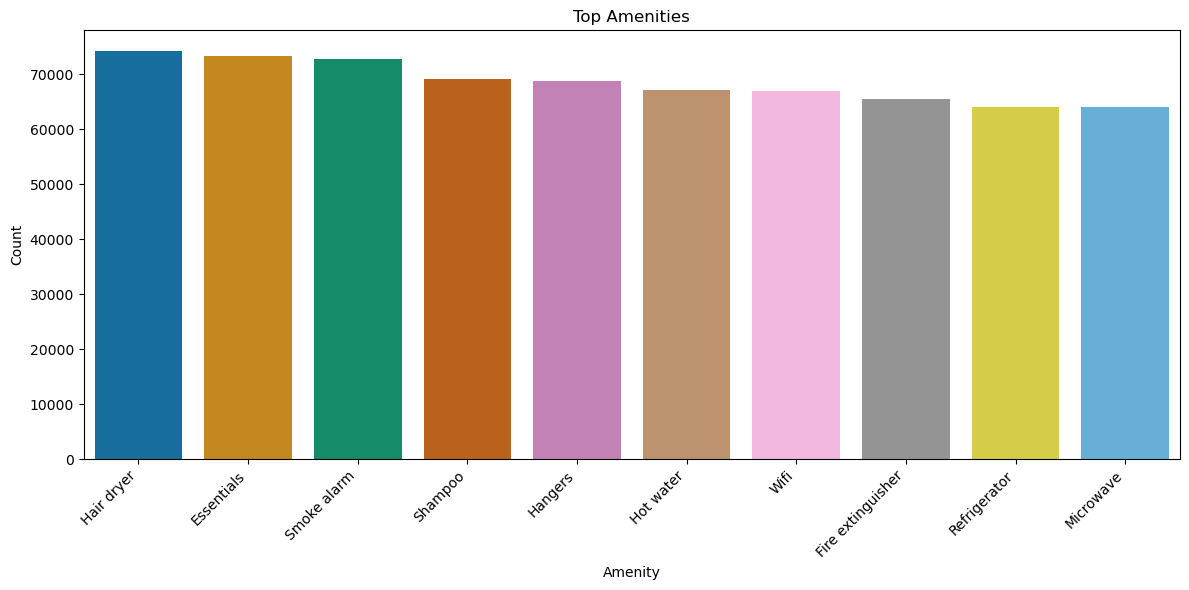

In [47]:
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

sns.barplot(x=top_amenities_counts.index, y=top_amenities_counts.values)

plt.xticks(rotation=45, ha='right')

plt.title('Top Amenities')
plt.xlabel('Amenity')
plt.ylabel('Count')
plt.tight_layout() 
plt.show()


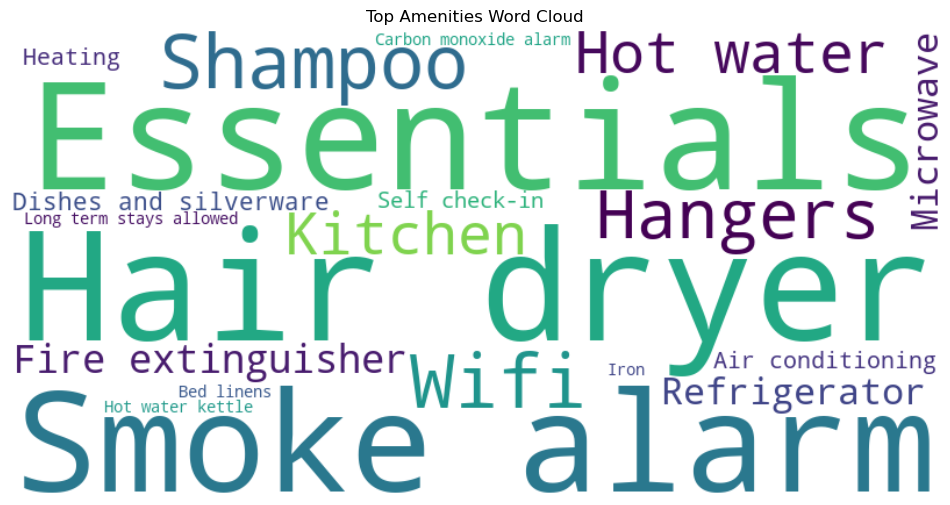

In [64]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_amenities_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Top Amenities Word Cloud')
plt.show()


* Convert amenities from categorical to numerical

In [25]:
df['reviewer_id'].nunique()

67632

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74975 entries, 0 to 74974
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              74975 non-null  int64         
 1   date                    74975 non-null  datetime64[ns]
 2   reviewer_id             74975 non-null  int64         
 3   reviewer_name           74975 non-null  object        
 4   comments                74965 non-null  object        
 5   listing_url             74975 non-null  object        
 6   name                    74975 non-null  object        
 7   description             74975 non-null  object        
 8   neighborhood_overview   54749 non-null  object        
 9   picture_url             74975 non-null  object        
 10  neighborhood            74975 non-null  object        
 11  latitude                74975 non-null  float64       
 12  longitude               74975 non-null  float6

# Finding most reviewed properties

In [146]:

# Filter the DataFrame to show listings where the same reviewer reviewed multiple properties
duplicated_reviewers = df[df.duplicated('reviewer_id', keep=False)]

# Display the relevant columns for these listings
relevant_columns = ['reviewer_id', 'listing_id', 'number_of_reviews', 'rating']
result = duplicated_reviewers[relevant_columns].sort_values(by='reviewer_id')
result.head()


,reviewer_id,listing_id,number_of_reviews,rating
84456,51865,16409316,240,4.85
414688,51865,628785146348461723,19,4.89
298330,56895,40093874,53,4.83
368509,56895,47151937,46,4.96
243591,82275,33697267,83,4.83


In [119]:
# find the maximum number of reviews for each listing_id
max_review_counts = df.groupby('listing_id')['number_of_reviews'].max()

# Find the listing with the highest number of reviews
most_reviewed_listing = max_review_counts.idxmax()
most_reviews = max_review_counts.max()

print(f"The most reviewed property is {most_reviewed_listing} with {most_reviews} reviews.")


The most reviewed property is 27750681 with 2023 reviews.


In [131]:
# Find the maximum number of reviews for each listing_id
max_review_counts_list = df.groupby('listing_id')['number_of_reviews'].max()

# Sort the listings by the number of reviews in descending order
sorted_listings = max_review_counts_list.sort_values(ascending=False)

# Select the top 10 or 20 listings
top_10_listings = sorted_listings.head(10)
top_20_listings = sorted_listings.head(20)

# Convert the top 10 listing IDs to a list
top_10_listing_ids = top_10_listings.index.tolist()

# Filter the original DataFrame for these top 10 IDs
top_10_listings_details = df[df['listing_id'].isin(top_10_listing_ids)]

# Since the same listing_id can appear multiple times in df, drop duplicates
top_10_listings_details = top_10_listings_details.drop_duplicates(subset='listing_id')

# Display the detailed information for these top 10 listings
print("Detailed columns of top 10 most reviewed properties:")
top_10_listings_details


# Display the results
#print("Top 10 most reviewed properties:")
#top_10_listings
#print("\nTop 20 most reviewed properties:")
#print(top_20_listings)


Detailed columns of top 10 most reviewed properties:


,listing_id,date,reviewer_id,reviewer_name,comments,listing_url,name,description,neighborhood_overview,picture_url,...,bathrooms_text,bedrooms,beds,amenities,price,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,rating
15384,4050925,2023-05-02,421642071,Farkvam,Great stay and will definitely be back ! Thank...,https://www.airbnb.com/rooms/4050925,Home in Taito city · ★4.94 · 2 bedrooms · 1 bath,<b>The space</b><br />-pick-up service 9 guest...,NaN,https://a0.muscache.com/pictures/50965406/7da8...,...,1 bath,2.0,NaN,"[""Luggage dropoff allowed"", ""Free washer \u201...","$40,000.00",t,547,57,7,4.94
147530,25377337,2023-05-03,227130046,Robert,"Good place, very cozy and near station",https://www.airbnb.com/rooms/25377337,Boutique hotel in 中央区 · ★4.78 · 1 bedroom · 3 ...,❇︎Sales have been suspended since May due to r...,Tokyo Central Cruising within a 20-minute walk...,https://a0.muscache.com/pictures/5fbf88f8-9eb5...,...,1 private bath,1.0,3.0,"[""Luggage dropoff allowed"", ""Dedicated workspa...","$29,755.00",t,779,74,2,4.78
153000,25924772,2023-05-04,44038055,Pan & Aditya,Perfect place for a short stay. Well kept and ...,https://www.airbnb.com/rooms/25924772,Hostel in Taitō-ku · ★4.68 · 1 bedroom · 36 be...,"Set in Tokyo, 1.1 km from Sensoji Temple, Host...",Hostel Kura offers the best location in Tokyo ...,https://a0.muscache.com/pictures/1fc14b5b-8582...,...,4 shared baths,1.0,36.0,"[""Fire extinguisher"", ""Essentials"", ""Shampoo"",...","$5,571.00",t,535,127,5,4.68
171275,27750681,2023-05-01,45963798,Tess,"Overall a great stay. Excellent location, Davi...",https://www.airbnb.com/rooms/27750681,Rental unit in Tokyo · ★4.67 · 1 bedroom · 2 b...,Located in the heart of the city with close ac...,Shinjuku is an exciting and vibrant neighborho...,https://a0.muscache.com/pictures/306813ea-f2e0...,...,1 bath,1.0,2.0,"[""Luggage dropoff allowed"", ""Dedicated workspa...","$15,631.00",t,2023,873,56,4.67
344166,44125369,2023-05-01,275676896,Alfonso De Andres,The location is amazing. The staff is super he...,https://www.airbnb.com/rooms/44125369,Boutique hotel in Taito City · ★4.67 · 1 bedro...,"・Spatial design with the motif of ""MANGA"" whic...",Surrounding spots *<br />Edo Shitamachi Tradit...,https://a0.muscache.com/pictures/f8e4cb43-8cd9...,...,1 private bath,1.0,2.0,"[""Books and reading material"", ""Luggage dropof...","$13,243.00",t,966,909,43,4.67
348943,44637473,2023-05-01,63562204,Blair,Great place for our family to stay. Comfortabl...,https://www.airbnb.com/rooms/44637473,Boutique hotel in 新宿区 · ★4.83 · 1 bedroom · 4 ...,1フロアに1室の贅沢設計。<br />恋人・夫婦、特別な人とのご利用におすすめです。<br ...,大正、昭和の名立たる文人たちがこよなく愛し、住み継いできた神楽坂。今でも歴史を感じる街並みの...,https://a0.muscache.com/pictures/c576c785-1d3e...,...,1 private bath,1.0,4.0,"[""Luggage dropoff allowed"", ""Dedicated workspa...","$30,326.00",t,782,268,16,4.83
377118,49084102,2023-05-03,382384592,Fajri,"Large of room, I bring 3 kiddos there, kitchen...",https://www.airbnb.com/rooms/49084102,Serviced apartment in Edogawa City · ★4.83 · S...,"June 2021, GRAND OPENING！<br />✅KASAI Sta.➡ 3m...",◆3min from Kasai Sta.<br />◆About 30min to pop...,https://a0.muscache.com/pictures/miso/Hosting-...,...,1 bath,NaN,3.0,"[""Microwave"", ""Hangers"", ""Induction stove"", ""B...","$7,429.00",t,971,536,39,4.83
381174,49470166,2023-05-01,175049089,Michelle,Very convenient location in a quiet neighborho...,https://www.airbnb.com/rooms/49470166,Aparthotel in Shinagawa Ku · ★4.84 · 1 bedroom...,THREE大井町は、東京 23 区の品川区に位置しています。 空港や新幹線の駅からもアクセス...,NaN,https://a0.muscache.com/pictures/c7485f26-ce45...,...,1 bath,1.0,2.0,"[""Dedicated workspace"", ""Private entrance"", ""M...","$11,143.00",t,539,349,23,4.84
383612,49506633,2023-05-02,163754827,Jenny,Very nice stay,https://www.airbnb.com/rooms/49506633,Aparthotel in Taito City · ★4.84 · 1 bedroom ·...,シングルベッド2台・ダブルベッド2台・ソファベッド2台（ロフト仕様）、調理器具とキッチン付き...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,...,1 bath,1.0,6.0,"[""Microwave"", ""Stove"", 

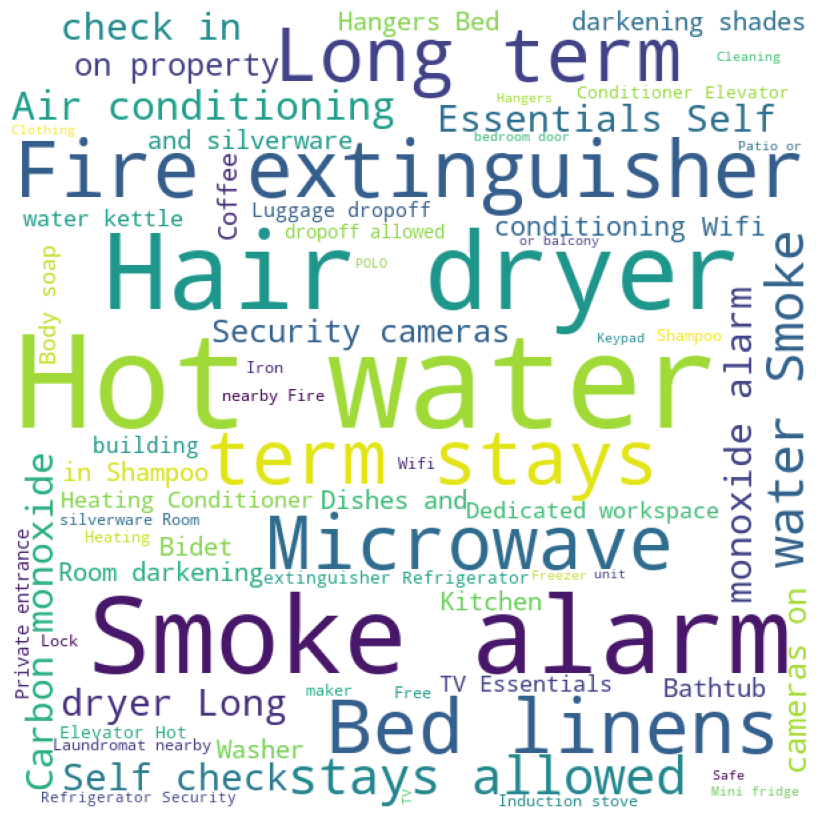

In [138]:
# Wordcloud for amenities in top 10 listings
all_amenities = []
for amenities_str in top_10_listings_details['amenities']:
    amenities_list = ast.literal_eval(amenities_str)
    all_amenities.extend(amenities_list)

all_amenities_text = ' '.join(all_amenities)

wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = set(), 
                min_font_size = 10).generate(all_amenities_text)
                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()



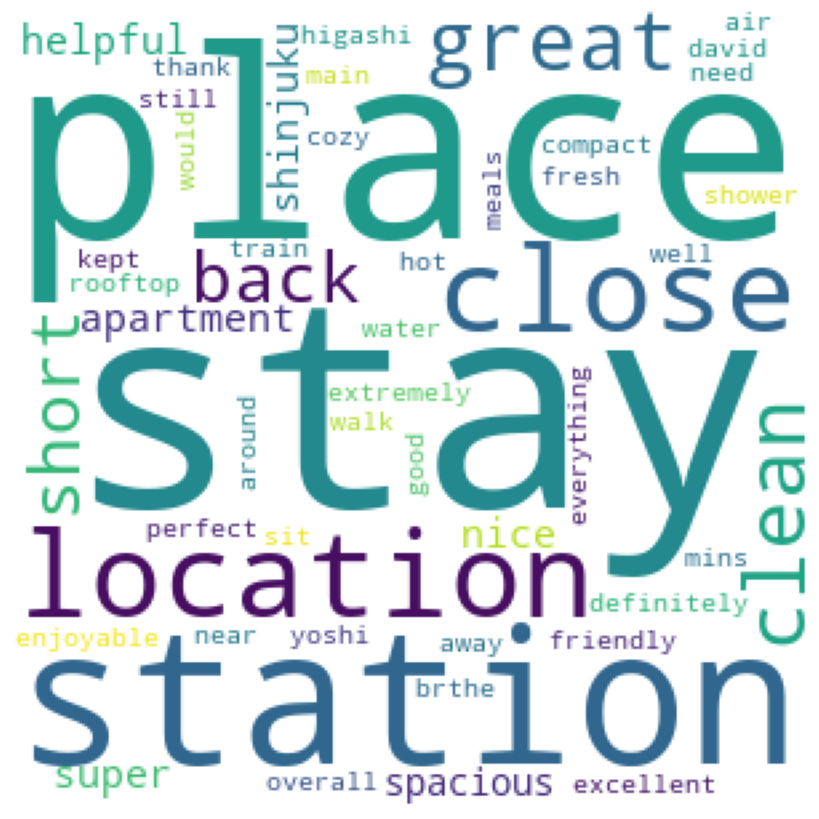

In [147]:
# Wordcloud for reviews for top 10 listings
all_comments = ' '.join(top_10_listings_details['comments'].astype(str))
all_comments = all_comments.lower()
all_comments = re.sub(r'[^\w\s]', '', all_comments)
stop_words = set(stopwords.words('english'))
all_comments = ' '.join([word for word in all_comments.split() if word not in stop_words])

wordcloud = WordCloud(width = 300, height = 300, 
                background_color ='white', 
                stopwords = set(), 
                min_font_size = 10).generate(all_comments)
                      
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


# Data processing for Modeling

# # Modeling with a sample for computational efficiency

In [12]:
# Select only the relevant columns and selecting a random sample
# Model crashed while running on the full data
sampled_df = df.sample(frac=0.5)
new_df = sampled_df[['reviewer_id', 'listing_id', 'rating']]

In [14]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37488 entries, 244485 to 296049
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              37488 non-null  int64         
 1   date                    37488 non-null  datetime64[ns]
 2   reviewer_id             37488 non-null  int64         
 3   reviewer_name           37488 non-null  object        
 4   comments                37484 non-null  object        
 5   listing_url             37488 non-null  object        
 6   name                    37488 non-null  object        
 7   description             37488 non-null  object        
 8   neighborhood_overview   27412 non-null  object        
 9   picture_url             37488 non-null  object        
 10  neighborhood            37488 non-null  object        
 11  latitude                37488 non-null  float64       
 12  longitude               37488 non-null  float

In [15]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5)) 

# Load the dataset into Surprise
data = Dataset.load_from_df(new_df, reader)


In [16]:
full_dataset = data.build_full_trainset()

#view the number of users and items
print('Number of users: ', full_dataset.n_users, '\n')
print('Number of items: ', full_dataset.n_items)

Number of users:  35574 

Number of items:  6347


In [17]:
trainset, testset = train_test_split(data, test_size=0.2,random_state=42)

In [18]:
#function for outputting the accuracy predictions on an algorithm

def train_and_test_pred (algo, trainset, testset): 
    algo.fit(trainset)
   
    train_predictions = algo.test(trainset.build_testset())
    print('biased accuracy on train set: ')
    print(accuracy.rmse(train_predictions))
    print(accuracy.mae(train_predictions))
    test_predictions = algo.test(testset)
    print('unbiased accuracy on test set: ')
    print(accuracy.rmse(test_predictions))
    print(accuracy.mae(test_predictions))

# Baseline Model - KNN

In [19]:
baseline_model = KNNBasic()
train_and_test_pred(baseline_model, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
7.855413407917487e-16
MAE:  0.0000
3.2851347517584657e-16
unbiased accuracy on test set: 
RMSE: 0.1887
0.18873236603398896
MAE:  0.1460
0.145966844909893


In [50]:
#Scores for KNN Basic via cross validation
cv_knn_basic = cross_validate(baseline_model, data)
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))
print("mean test mae", np.mean(cv_knn_basic['test_mae']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
mean test rmse 0.18745348396798162
mean test mae 0.1453604014210758


## Interpretation

The extremely low RMSE and MAE values on the training set indicate that the model is perfectly fitting the training data. The average RMSE is 0.18, the model is relatively consistent in its performance across different subsets of data. 

# SVD

In [54]:
## Scores for Baseline SVD Crossvalidation

svd = SVD()
cv_svd = cross_validate(svd, data)
print("mean test rmse", np.mean(cv_svd['test_rmse']))

mean test rmse 0.13363299239637078


In [22]:
train_and_test_pred(svd, trainset, testset)

biased accuracy on train set: 
RMSE: 0.1063
0.10628429367009054
MAE:  0.0809
0.080851464530566
unbiased accuracy on test set: 
RMSE: 0.1357
0.135663471213612
MAE:  0.0975
0.09747426361651086


* Gridsearch with SVD

In [23]:
# performing a gridsearch with SVD

params = {
    'n_factors': [100,150,200],
    'n_epochs': [20,80,100],
    'lr_all': [0.008,0.01],
    'reg_all': [0.07,0.1]
}

SVD_grid = GridSearchCV(SVD, param_grid = params, cv=5)
SVD_grid.fit(data)

In [24]:
#view grid search results
print(SVD_grid.best_params)
print(SVD_grid.best_score)

{'rmse': {'n_factors': 100, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}, 'mae': {'n_factors': 100, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.07}}
{'rmse': 0.09618881354566708, 'mae': 0.06618889934666808}


In [25]:
## choose the best algo
svd_best_algo = SVD_grid.best_estimator['rmse']

In [26]:
train_and_test_pred(svd_best_algo, trainset, testset)

biased accuracy on train set: 
RMSE: 0.0125
0.012490262875696644
MAE:  0.0096
0.00959875057236664
unbiased accuracy on test set: 
RMSE: 0.0989
0.0988872339836862
MAE:  0.0677
0.0677266724447582


In [51]:
#Scores for Best SVD via cross validation
cv_best_svd = cross_validate(svd_best_algo, data)
print("mean test rmse", np.mean(cv_best_svd['test_rmse']))
print("mean test mae", np.mean(cv_best_svd['test_mae']))

mean test rmse 0.09634714241435172
mean test mae 0.06676785519818533


## Interpretation

Average RMSE is 0.096. The tuned SVD model shows an improvement in predictive accuracy over the baseline SVD model, as shown by lower RMSE and MAE scores.

# KNN Basic

In [55]:
## Scores for Baseline KNNBasic Crossvalidation
# item based filtering
knn_basic = KNNBasic(sim_options={"name": 'pearson', 'user_based':False})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))

python(60406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
mean test rmse 0.18753883423840395


In [32]:
train_and_test_pred(knn_basic, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
0.0
MAE:  0.0000
0.0
unbiased accuracy on test set: 
RMSE: 0.1887
0.18874436393554955
MAE:  0.1460
0.14600546594574818


In [33]:
## GridSearch with KNNBasic
params = {
    'k': [20,40,60],
    'sim_options': {
        'name':['msd', 'cosine', 'pearson'],
        'user_based': [False]   
    }
}
KNNBasic_grid = GridSearchCV(KNNBasic, param_grid = params, cv=5)
KNNBasic_grid.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

In [34]:
#view grid search results
print(KNNBasic_grid.best_params)
print(KNNBasic_grid.best_score)

{'rmse': {'k': 20, 'sim_options': {'name': 'pearson', 'user_based': False}}, 'mae': {'k': 20, 'sim_options': {'name': 'pearson', 'user_based': False}}}
{'rmse': 0.18759205770985118, 'mae': 0.14550985159312843}


In [35]:
#take the best model and 
#test on train/test 
KNNbasic_best_algo = KNNBasic_grid.best_estimator['rmse']
train_and_test_pred(KNNbasic_best_algo, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
0.0
MAE:  0.0000
0.0
unbiased accuracy on test set: 
RMSE: 0.1887
0.18874436393554955
MAE:  0.1460
0.14600546594574818


In [36]:
#Scores for Best KNNbasic via cross validation
cv_best_knnbasic = cross_validate(KNNbasic_best_algo, data)
print(np.mean(cv_best_knnbasic['test_rmse']))
print(np.mean(cv_best_knnbasic['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.1874956094330123
0.1454412204199254


# KNN Baseline

In [37]:
##view our cross validation score with KNNBaseline:
knn_baseline = KNNBaseline(sim_options={"name": 'pearson', 'user_based':False})
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [38]:
train_and_test_pred(knn_baseline, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
7.928863374242852e-17
MAE:  0.0000
7.078180803878958e-18
unbiased accuracy on test set: 
RMSE: 0.1355
0.13554711760293134
MAE:  0.0983
0.0983182013061225


# Note - This took over an hour to run

In [39]:
## GridSearch with KNNBaseline

params = {
    'k': [10,20,40,50],
    'sim_options': {
        'name':['msd', 'cosine', 'pearson'],
    },
    'bsl_options': {
        "method": ["als","sgd"],
        'reg': [0.02,0.5, 1, 2],
        'n_epochs': [20,40]
    }
}
KNNBaseline_grid = GridSearchCV(KNNBaseline, param_grid = params, cv=5)
KNNBaseline_grid.fit(data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [40]:
#view grid search results
print(KNNBaseline_grid.best_params)
print(KNNBaseline_grid.best_score)

{'rmse': {'k': 10, 'sim_options': {'name': 'pearson', 'user_based': True}, 'bsl_options': {'method': 'sgd', 'reg': 0.02, 'n_epochs': 40}}, 'mae': {'k': 10, 'sim_options': {'name': 'pearson', 'user_based': True}, 'bsl_options': {'method': 'sgd', 'reg': 0.02, 'n_epochs': 40}}}
{'rmse': 0.09960220879552531, 'mae': 0.06509498190836052}


In [41]:
#take the best model and 
#test on train/test 
KNNbaseline_best_algo = KNNBaseline_grid.best_estimator['rmse']
train_and_test_pred(KNNbaseline_best_algo, trainset, testset)

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
6.002387981598243e-07
MAE:  0.0000
9.442090213338261e-09
unbiased accuracy on test set: 
RMSE: 0.1018
0.10181890908797658
MAE:  0.0657
0.06570364495103315


In [53]:
#Scores for Best KNN Baseline via cross validation
cv_best_knnbaseline = cross_validate(KNNbaseline_best_algo, data)
print("mean test rmse", np.mean(cv_best_knnbaseline['test_rmse']))

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
mean test rmse 0.09955186732525627


# NMF

In [44]:
#Baseline NMF cross validation scores
nmf = NMF()

cv_nmf = cross_validate(nmf, data)
print(np.mean(cv_nmf['test_rmse']))
print(np.mean(cv_nmf['test_mae']))

0.32876125234034226
0.2039276658536992


In [45]:
## GridSearch with NMF
## note: this took 11 minutes to run
params = {
    'n_factors': [10,15,20,25,30],
    "n_epochs": [25,50,75,100],
    "reg_pu": [0.06,0.1],
    "reg_qi": [0.06,0.1]
}
nmf_grid = GridSearchCV(NMF, param_grid = params, cv=5)
nmf_grid.fit(data)

In [46]:
#view grid search results
print(nmf_grid.best_params)
print(nmf_grid.best_score)

{'rmse': {'n_factors': 10, 'n_epochs': 25, 'reg_pu': 0.06, 'reg_qi': 0.06}, 'mae': {'n_factors': 10, 'n_epochs': 25, 'reg_pu': 0.06, 'reg_qi': 0.06}}
{'rmse': 0.20554663494470327, 'mae': 0.1564710974364346}


In [47]:
#take the best model and 
#test on train/test 
nmf_best = nmf_grid.best_estimator['rmse']
train_and_test_pred(nmf_best, trainset, testset)

biased accuracy on train set: 
RMSE: 0.3225
0.3224809953760588
MAE:  0.2717
0.27174718311014495
unbiased accuracy on test set: 
RMSE: 0.2078
0.20781888677338925
MAE:  0.1573
0.15730984154987643


In [52]:
#Scores for Best NMF via cross validation
cv_best_nmf = cross_validate(nmf_best, data)
print("mean test rmse", np.mean(cv_best_nmf['test_rmse']))

mean test rmse 0.2065416968707093


* Interpretation - Highest RMSE among the models tested. Overall still very low but other models performed better

# Comparing Models

In [ ]:
KNNBaseline 0.099
KNNBasic 0.187
SVD 0.096
NMF 0.206


SVD has the lowest RMSE 0.096, indicating the highest predictive accuracy among the models tested

# Making simple predictions

In [59]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,city scrape,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
1,5240174,https://www.airbnb.com/rooms/5240174,20230924051543,2023-09-24,previous scrape,Rental unit in Shibuya-ku · ★4.52 · Studio · 1...,Minimalist simple grey-color interior room. My...,NaN,https://a0.muscache.com/pictures/b0b55fef-80cb...,24477517,...,4.83,4.29,4.30,M130005396,t,4,4,0,0,1.89
2,5262640,https://www.airbnb.com/rooms/5262640,20230924051543,2023-09-24,city scrape,Rental unit in Nakano-ku · ★4.80 · 1 bedroom ·...,It takes 5 min walk to Fujimidai Sta.. You can...,No smoking in the room<br />No outdoor shoes a...,https://a0.muscache.com/pictures/281f8d6f-eb4a...,17736560,...,4.87,4.61,4.77,Hotels and Inns Business Act | 中野区保健所 | 30中環生環...,f,9,9,0,0,0.59
3,776070,https://www.airbnb.com/rooms/776070,20230924051543,2023-09-24,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.84,4.91,M130000243,f,1,0,1,0,1.88
4,905944,https://www.airbnb.com/rooms/905944,20230924051543,2023-09-24,city scrape,Rental unit in Shibuya · ★4.77 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.78,4.78,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.52


In [57]:
best_model = SVD(n_factors= 100, n_epochs= 100, lr_all= 0.01, reg_all=0.1)
best_model.fit(trainset)


In [58]:
best_model.test(testset)
accuracy.rmse(best_model.test(testset))

RMSE: 0.0986


0.0985778110618089

In [60]:
best_model.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=4.72041947315772, details={'was_impossible': False})

# Function to rate properties for recommendations for new user

In [106]:
def airbnb_rater(listings, num, room_type=None):
    reviewer_id = 7000
    rating_list = []

    while num > 0:
        if room_type:
            listing = listings[listings['room_type'].str.contains(room_type)].sample(1)
        else: 
            listing = listings.sample(1)

        print(f"Name: {listing['name'].values[0]}")
        print(f"URL: {listing['listing_url'].values[0]}")
        print(f"Description: {listing['description'].values[0]}")
        print(f"Neighborhood: {listing['neighbourhood_cleansed'].values[0]}")

        # Get user rating
        rating = input('How do you rate this listing on a scale of 1-5, press n if you have not stayed here:\n')
        try:
            if 1 <= int(rating) <= 5:
                rating_listing = {'reviewer_id': reviewer_id, 'listing_id':listing['id'].values[0], 'rating': rating}
                rating_list.append(rating_listing)
                num -= 1
        except:
            print('Please enter a valid rating from 1-5')
            continue
    return rating_list

In [99]:
listings.loc[listings["id"]== 197677]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,city scrape,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19


In [108]:
user_rating = airbnb_rater(listings, 5)

Name: Rental unit in Toshima City · ★4.45 · 1 bedroom · 1 bath
URL: https://www.airbnb.com/rooms/52908934
Description: Newly built in 2018, this is a cozy and high quality apartment which is only 5 mins on foot from Otsuka Station. Highly accessible to Shibuya, Harajuku, Ueno, Asakusa, Shinjuku, Tokyo,Ikebukuro, Roppongi, Akihabara by JR Yamanote Line without transfer. Besides, all furniture and electrical appliances are all brand new and all you may need for Tokyo living just one step away from my house.<br /><br /><b>The space</b><br />-If you’re looking for a change of pace from the hyperactivity of Tokyo, this area is for you. Otsuka has the nostalgic feeling of downtown Edo (old Tokyo). Tucked within its back streets are small shopping arcades and old izakaya.<br /><br /><br />-From Otsuka station by train it is directly to Tokyo station, Akihabara station, Ikebukuro station, Shin Okubo station, Shinjuku station, Shibuya station, Tokyo station and so on, so do not worry about gett

In [ ]:
user_ratings = pd.DataFrame(user_rating)
new_ratings_df = pd.concat([listings, user_ratings], axis=0)

# Convert empty strings to NaN and drop them
new_ratings_df['rating'].replace('', np.nan, inplace=True)
new_ratings_df.dropna(subset=['rating'], inplace=True)

# Convert data types
new_ratings_df['userId'] = new_ratings_df['userId'].astype(int)
new_ratings_df['listingId'] = new_ratings_df['listingId'].astype(int)
new_ratings_df['rating'] = new_ratings_df['rating'].astype(float)

# Load into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_ratings_df[['userId', 'listingId', 'rating']], reader)


In [88]:
trainset = data.build_full_trainset()
algo = SVD(n_factors= 100, n_epochs= 100, lr_all= 0.01, reg_all=0.1)
algo.fit(trainset)

In [90]:
# Make predictions for the new user
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

# Order predictions and return top recommendations
from collections import defaultdict

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=5)

new_user_recommendations = top_n[1000]

# Display the recommendations with listing details
for listing_id, estimated_rating in new_user_recommendations:
    listing = listings_df[listings_df['id'] == listing_id].iloc[0]
    print(f"Listing: {listing['name']}, Estimated Rating: {estimated_rating}")
